---
title: "DS202W - Spring Term Summative"
author: "4598"
format: 
  html:
    self-contained: true
    toc: true
    toc-depth: 2
    code-fold: true
    code-tools: true
    number-sections: true
    theme: cosmo
    highlight-style: github
    html-math-method: mathjax
jupyter: python3
engine: jupyter
editor:
  render-on-save: true
  preview: true
lang: en
---


## Package Installation
This project uses the following Python libraries for data processing, natural language processing, and unsupervised learning.

### Core packages
```bash
pip install pandas numpy matplotlib seaborn scikit-learn tqdm
```

### Additional libraries
```bash
pip install scikit-learn
pip install umap
pip install matplotlib
pip install seaborn
pip install spacy wordcloud langdetect
python -m spacy download en_core_web_sm
pip install wordcloud
pip install pandas
pip install numpy

```

In [40]:
# General utilities
import os
import re
import warnings
from glob import glob
from datetime import datetime
from collections import defaultdict, Counter

# Data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP tools
import spacy
from tqdm.notebook import tqdm
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

# NLTK based pre-processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Feature extraction and modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity

# Configure warnings
warnings.filterwarnings('ignore')

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Import umap 
import umap 

# Part One: Similarity Analysis Using Reddit Mental Health Data

### Working with the data 

In [12]:
labelled_data_folder = os.path.join("reddit_data", "Original Reddit Data", "Labelled Data")

# List all CSV files in the labeled data folder
csv_files = glob(os.path.join(labelled_data_folder, "*.csv"))

# Define flexible column mapping for the labeled dataset
COLUMN_ALIASES = {
    'Selftext': ['Selftext', 'selftext', 'body', 'text'],
    'Subreddit': ['Subreddit', 'subreddit'],
    'Title': ['Title', 'title'],
    'Score': ['Score', 'score'],
    'Timestamp': ['Timestamp', 'timestamp', 'created_utc'],
    'Label': ['Label', 'label']
}

# Function to normalize column names based on aliases
def normalize_columns(df):
    col_map = {}
    for std_name, possible_names in COLUMN_ALIASES.items():
        for name in possible_names:
            if name in df.columns:
                col_map[name] = std_name
                break
    return df.rename(columns=col_map)

# Read the labeled data files, normalize columns, and filter only labeled data
dfs = []

for file in csv_files:
    try:
        print(f"Reading: {file}")
        df = pd.read_csv(file, low_memory=False)
        df = normalize_columns(df)

        # Standardize label field early to avoid issues
        if 'Label' in df.columns:
            df['Label'] = df['Label'].astype(str).str.strip()
            df_labeled = df[df['Label'].str.len() > 0]

            keep_cols = ['Selftext', 'Subreddit', 'Label'] + [col for col in ['Title', 'Score', 'Timestamp'] if col in df_labeled.columns]
            df_labeled = df_labeled[keep_cols]

            dfs.append(df_labeled)
        else:
            print(f"Skipping {file} — missing 'Label' column.")
    except Exception as e:
        print(f"Skipping {file} — {str(e)}")

# Concatenate all labeled data
if dfs:
    df_labeled_all = pd.concat(dfs, ignore_index=True).reset_index(drop=True)

    # Final label cleanup
    df_labeled_all['Label'] = df_labeled_all['Label'].str.strip().str.title()
    df_labeled_all = df_labeled_all[
        df_labeled_all['Label'].notna() & (df_labeled_all['Label'].str.lower() != 'nan')
    ]

    print("Label distribution after standardizing:")
    print(df_labeled_all['Label'].value_counts())

    print("\nSample of cleaned labeled data:")
    print(df_labeled_all.head())
else:
    print("No valid labeled data to concatenate.")


Reading: reddit_data/Original Reddit Data/Labelled Data/LD EL1.csv
Reading: reddit_data/Original Reddit Data/Labelled Data/LD TS 1.csv
Reading: reddit_data/Original Reddit Data/Labelled Data/LD DA 1.csv
Reading: reddit_data/Original Reddit Data/Labelled Data/LD PF1.csv
Label distribution after standardizing:
Label
Early Life           200
Trauma And Stress    200
Drug And Alcohol     200
Personality          200
Name: count, dtype: int64

Sample of cleaned labeled data:
                                            Selftext Subreddit       Label  \
0  Of Covid-19. Of 2021. Of not getting the vacci...   Anxiety  Early Life   
1  i feel like im losing my mind, my health anxie...   Anxiety  Early Life   
2  This year I’ve realized I really fear death. M...   Anxiety  Early Life   
3  Hiya~ There have been a couple teenagers at wo...   Anxiety  Early Life   
4  I need some advice. I have anxiety, and I have...   Anxiety  Early Life   

                                               Title  Sc

## Dataset Selection Justification
This analysis is based on the labeled Reddit Mental Health dataset, which includes a curated set of user posts annotated with one of four psychological categories: Early Life, Personality, Trauma and Stress, and Drug and Alcohol. This decision reflects a balance between relevance, analytical focus, and practical constraints.

### Data Quality & Relevance
The labeled subset ensures that all analyzed posts are topically relevant and human-reviewed. Compared to the raw data—which contains off-topic discussions, memes, or incomplete threads—this dataset provides cleaner input aligned with the mental health themes central to this study. The category labels reflect clinically meaningful groupings, making them highly suitable for social science-oriented textual analysis.

### Analytical Focus
This task explores similarity within and across psychological categories. Using pre-labeled posts allows us to focus on comparing linguistic patterns between specific experiences or mental health conditions, such as trauma vs. personality-related narratives. The structure of the data supports a clearly interpretable analysis grounded in these domains.

### Validation Capability
Having access to class labels enables us to validate similarity measures: for example, we can test whether intra-category similarity scores are consistently higher than inter-category ones. This provides a natural form of ground truth that would not be available with unlabeled raw posts, making the similarity analysis more meaningful and evaluative.

### Computational Efficiency
The labeled dataset contains a manageable number of posts (≈800), making it well-suited for experimenting with computationally intensive methods like vector space embeddings, clustering, or dimensionality reduction. This avoids the memory and performance bottlenecks that could arise when working with the full corpus of Reddit mental health posts.

### Scope and Limitations
This selection introduces some sampling bias—posts included in the labeled dataset may not fully represent the diversity or nuance of real-world Reddit discourse. However, the goal here is not to generalize to the entire mental health ecosystem, but to test and evaluate similarity approaches in a controlled, interpretable setting. The focus is on producing a proof-of-concept analysis that could be scaled up in future work.

In [13]:
# Split the full dataset into per-label DataFrames
reddit_da_data = df_labeled_all[df_labeled_all['Label'] == 'Drug And Alcohol'].copy()
reddit_el_data = df_labeled_all[df_labeled_all['Label'] == 'Early Life'].copy()
reddit_pf_data = df_labeled_all[df_labeled_all['Label'] == 'Personality'].copy()
reddit_ts_data = df_labeled_all[df_labeled_all['Label'] == 'Trauma And Stress'].copy()

# Print shape and preview for one of them
print(f"DA Data Shape: {reddit_da_data.shape}")
print("\nData Head:")
print(reddit_da_data.head())

DA Data Shape: (200, 5)

Data Head:
                                              Selftext Subreddit  \
400  Tried to watch this documentary “anxious Ameri...   Anxiety   
401  i’m currently laying in bed wide awake, feelin...   Anxiety   
402  Second time trying weed. First time felt close...   Anxiety   
403  I am not posting this for me, but rather for m...   Anxiety   
404  21 year old male been dealing with anxiety eve...   Anxiety   

                Label                                              Title  \
400  Drug And Alcohol                        Do people get over anxiety?   
401  Drug And Alcohol  does anyone else have this big fear of suddenl...   
402  Drug And Alcohol         3 hour long panic attack after trying weed   
403  Drug And Alcohol  Please leave in the comments ANYTHING that has...   
404  Drug And Alcohol                                    Alcohol induced   

     Score  
400    1.0  
401    1.0  
402    2.0  
403    1.0  
404    1.0  


In [14]:
# Concatenate into one dataframe 
reddit_labelled_data = pd.concat([reddit_da_data, reddit_el_data, reddit_pf_data, reddit_ts_data])

# Check for null values 
print("\nNull Values:")
print(reddit_labelled_data.isnull().sum())

# Drop data points for which all columns are null
reddit_labelled_data.dropna(how='all', inplace=True)

print(f"DF shape: {reddit_labelled_data.shape}")

print("\nData Head:")
reddit_labelled_data.head()


Null Values:
Selftext     0
Subreddit    0
Label        0
Title        0
Score        0
dtype: int64
DF shape: (800, 5)

Data Head:


,Selftext,Subreddit,Label,Title,Score
400,Tried to watch this documentary “anxious Ameri...,Anxiety,Drug And Alcohol,Do people get over anxiety?,1.0
401,"i’m currently laying in bed wide awake, feelin...",Anxiety,Drug And Alcohol,does anyone else have this big fear of suddenl...,1.0
402,Second time trying weed. First time felt close...,Anxiety,Drug And Alcohol,3 hour long panic attack after trying weed,2.0
403,"I am not posting this for me, but rather for m...",Anxiety,Drug And Alcohol,Please leave in the comments ANYTHING that has...,1.0
404,21 year old male been dealing with anxiety eve...,Anxiety,Drug And Alcohol,Alcohol induced,1.0


## Dataset Preparation Summary

The labeled Reddit mental health data was loaded from multiple CSV files using a dynamic folder search. Column names were normalized across files to account for variations (e.g., different casing or naming conventions).

Each file was filtered to include only rows with valid labels and relevant columns (Selftext, Subreddit, Label, and optionally Title, Score, Timestamp). Label values were standardized (e.g., consistent casing), and all cleaned data was concatenated into a single DataFrame.

From this combined dataset, four separate DataFrames were created for each category: Drug and Alcohol, Early Life, Personality, and Trauma and Stress. These were then merged into a final labeled dataset with 800 entries (200 per category), with all missing or empty rows removed. The resulting dataset is now clean, balanced, and ready for similarity and clustering analysis.

## Using TF-IDF and LSA to Analyze Similarity Across Subreddits and Mental Health Categories

### Overview

This project applies both lexical and semantic similarity analysis to Reddit mental health data. Specifically, I examine how different subreddits and labeled mental health categories compare in terms of the language used. The workflow uses **TF-IDF vectorization** to capture lexical salience and **Latent Semantic Analysis (LSA)** to project texts into a lower-dimensional semantic space, enabling comparison across groups.

---

### Subreddit-Level Similarity (Lexical)

To begin, I compute cosine similarity across different mental health subreddits using the **average TF-IDF vectors** of posts within each subreddit. This approach reveals which communities use similar language, offering insight into how different subreddits frame mental health discourse.

- **Why TF-IDF?**  
  TF-IDF emphasizes terms that are locally frequent but globally rare. This helps surface subreddit-specific vocabulary (e.g., `panic`, `cope`, or `isolation`) while suppressing generic terms like `feel` or `like`.

- **Why Subreddits?**  
  Subreddits represent online communities with unique norms, language styles, and degrees of formality or vulnerability. Comparing them offers insight into how context and audience shape expression.

- **Output:**  
  A heatmap shows lexical similarity between subreddits. High similarity between `r/anxiety` and `r/depression`, for example, would indicate overlapping vocabularies and themes.

---

### Category-Level Semantic Similarity (LSA)

In parallel, I analyze similarity between **labeled categories**: *Early Life*, *Trauma and Stress*, *Drug and Alcohol*, and *Personality*. Rather than comparing raw TF-IDF vectors, I use **Latent Semantic Analysis** (LSA) to capture deeper, conceptual relationships.

- **Why LSA?**  
  LSA reduces the dimensionality of the TF-IDF matrix using `TruncatedSVD`, uncovering latent semantic structure in the text. This helps group terms and documents by conceptual similarity, even if different words are used.

- **Mean Category Embeddings:**  
  I compute a **mean vector** for each category by averaging the LSA vectors of its documents. This gives a single vector that represents the “semantic center” of each mental health theme.

- **Interpretability:**  
  A cosine similarity matrix shows how semantically close the categories are. This is especially useful for understanding thematic overlap — for example, whether "Trauma and Stress" is closely related to "Early Life".

- **Explained Variance Plot:**  
  I include a cumulative variance plot from LSA to validate the choice of 100 components. This plot shows how much semantic information is retained and confirms that the projection captures substantial structure from the original data.

---

### Summary of Workflow

- Preprocessing includes token cleaning, stopword removal, and lemmatization.
- Combined `Title` and `Selftext` for richer semantic context.
- TF-IDF vectorization is applied for both subreddit and category text.
- Cosine similarity is used for subreddit analysis directly on TF-IDF vectors.
- For categories, dimensionality is reduced using LSA before computing cosine similarity.
- Visualization includes heatmaps for semantic similarity and word clouds/bar charts for TF-IDF keyword analysis.

---

### Reflection

This dual approach—TF-IDF for subreddits and LSA for categories—allowed me to capture both surface-level lexical patterns and deeper conceptual similarities. In future work, this pipeline could be extended using hierarchical clustering, topic modeling, or metadata such as post score or timestamp to explore temporal or community-driven shifts in discourse.


In [15]:
# Initialize lemmatizer and stopwords list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Preprocessing function: clean, remove stopwords, lemmatize
def preprocess_text(text):
    text = re.sub(r'http\S+|www.\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    tokens = text.lower().split()  # Tokenize and lowercase
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]  # Lemmatize and remove stopwords
    return ' '.join(tokens)

# Apply preprocessing to the 'Selftext' column
df_labeled_all['cleaned_text'] = df_labeled_all['Selftext'].apply(preprocess_text)

# Preview the cleaned data
print(df_labeled_all[['Selftext', 'cleaned_text']].head())


                                            Selftext  \
0  Of Covid-19. Of 2021. Of not getting the vacci...   
1  i feel like im losing my mind, my health anxie...   
2  This year I’ve realized I really fear death. M...   
3  Hiya~ There have been a couple teenagers at wo...   
4  I need some advice. I have anxiety, and I have...   

                                        cleaned_text  
0  covid getting vaccine soon enough wish could h...  
1  feel like im losing mind health anxiety skyroc...  
2  year ive realized really fear death mother pas...  
3  hiya couple teenager work harass bully dont mi...  
4  need advice anxiety suffered childhood trauma ...  


### TF-IDF Vectorization and Subreddit Similarity

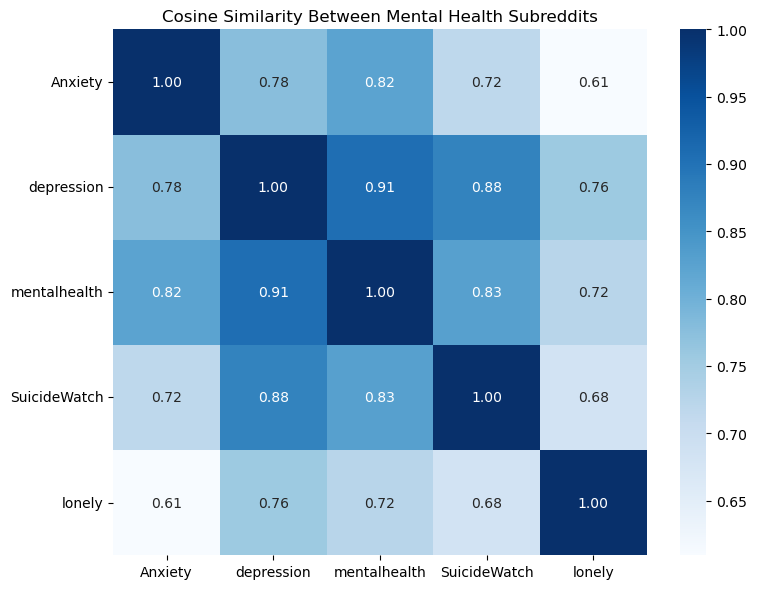

In [21]:
# Combine title and selftext for richer text input
df_labeled_all['combined_text'] = (
    df_labeled_all['Title'].fillna('') + ' ' + df_labeled_all['Selftext'].fillna('')
)
df_labeled_all['cleaned_text'] = df_labeled_all['combined_text'].apply(clean_text)

# Vectorize using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_labeled_all['cleaned_text'])

# List of unique subreddits
subreddits = df_labeled_all['Subreddit'].unique()

# Compute average TF-IDF vectors for each subreddit
subreddit_vectors = []
for subreddit in subreddits:
    mask = df_labeled_all['Subreddit'] == subreddit
    mean_vector = tfidf_matrix[mask].mean(axis=0)
    subreddit_vectors.append(mean_vector.A1)  # Convert to flat array

# Cosine similarity matrix
subreddit_similarity = cosine_similarity(subreddit_vectors)

# Visualize similarity
plt.figure(figsize=(8, 6))
sns.heatmap(subreddit_similarity, xticklabels=subreddits, yticklabels=subreddits,
            cmap="Blues", annot=True, fmt=".2f")
plt.title("Cosine Similarity Between Mental Health Subreddits")
plt.tight_layout()
plt.show()

### Interpreting Cosine Similarity Between Mental Health Subreddits

The heatmap above presents cosine similarity scores between average TF-IDF vectors for posts from five major mental health subreddits: **Anxiety**, **Depression**, **MentalHealth**, **SuicideWatch**, and **Lonely**. Cosine similarity values range from 0 (completely dissimilar) to 1 (identical), and here they reflect how similar the linguistic content of posts is across different communities.

#### Key Observations

- **Highest Similarity**:
  - The strongest similarity is between **Depression** and **MentalHealth** (0.91), suggesting that the topics and language used in these two subreddits overlap heavily. This makes sense given that both cover general and severe mood disorders and serve broad support communities.
  - **Depression** and **SuicideWatch** also have high similarity (0.88), likely due to shared vocabulary around crisis, emotional struggle, and coping mechanisms.

- **Lowest Similarity**:
  - The **Lonely** subreddit shows the lowest overall similarity with others, particularly with **Anxiety** (0.61). This indicates that conversations in *r/lonely* are more uniquely focused on themes of social isolation and interpersonal connection rather than clinical symptoms or mental illness terminology.
  - The relative distance between **Lonely** and other subreddits may also reflect differences in audience or emotional tone.

- **Moderate Similarity**:
  - **Anxiety** shares moderate similarity with both **Depression** (0.78) and **MentalHealth** (0.82), indicating thematic overlap but also highlighting the more specific nature of anxiety-related vocabulary.
  - **SuicideWatch** and **MentalHealth** (0.83) also align closely, likely due to shared language around crisis intervention and mental health support.

#### Interpretation

This analysis confirms that subreddits addressing broader or more clinical aspects of mental health (e.g., *r/depression*, *r/mentalhealth*) are more linguistically aligned. In contrast, subreddits that serve more niche or emotionally distinct communities (e.g., *r/lonely*) diverge in vocabulary and tone. These results illustrate how TF-IDF-based similarity can be used to understand community-level language use and thematic convergence in online mental health discourse.



Top terms for Early Life:
- im: 15.3323
- feel: 11.1333
- dont: 11.0391
- like: 10.8438
- know: 8.5941
- ive: 8.4948
- friend: 8.3527
- life: 8.3118
- year: 8.1262
- time: 7.6478
- want: 6.9984
- school: 6.6422
- really: 6.5262
- thing: 6.0667
- people: 5.7571


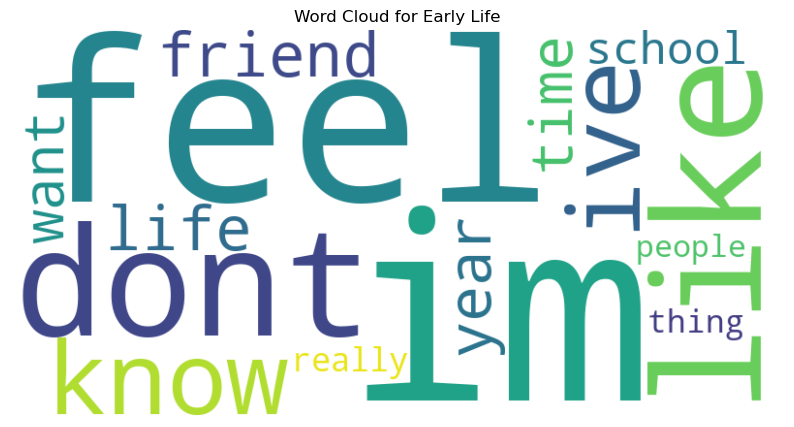

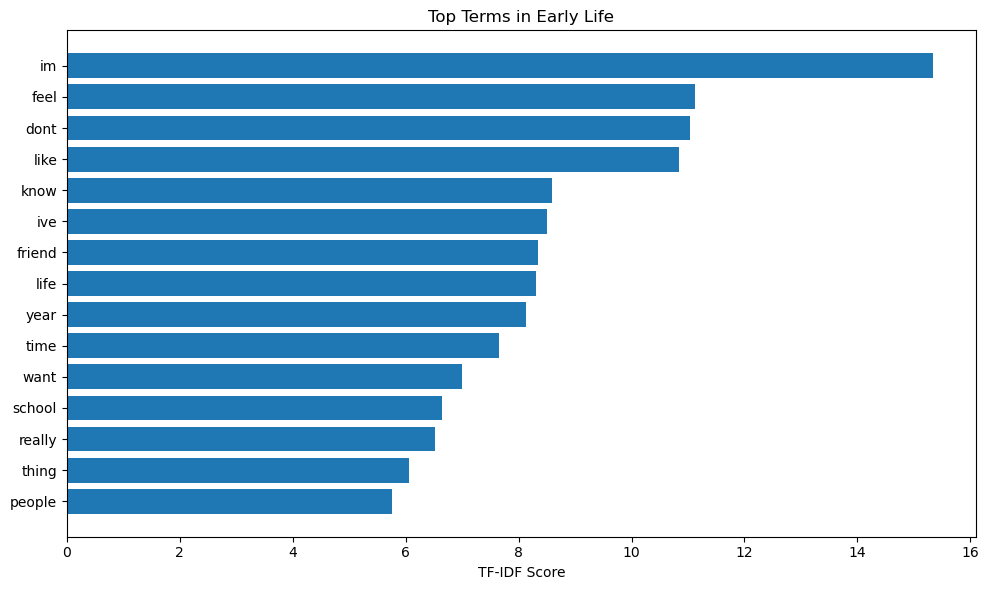


Top terms for Trauma And Stress:
- im: 16.0384
- dont: 11.2044
- feel: 11.0014
- like: 10.3673
- year: 9.9761
- want: 9.1585
- friend: 9.1255
- life: 7.6329
- know: 7.2516
- time: 6.9245
- really: 6.7449
- ive: 6.6308
- people: 6.3708
- day: 5.8050
- thing: 5.7840


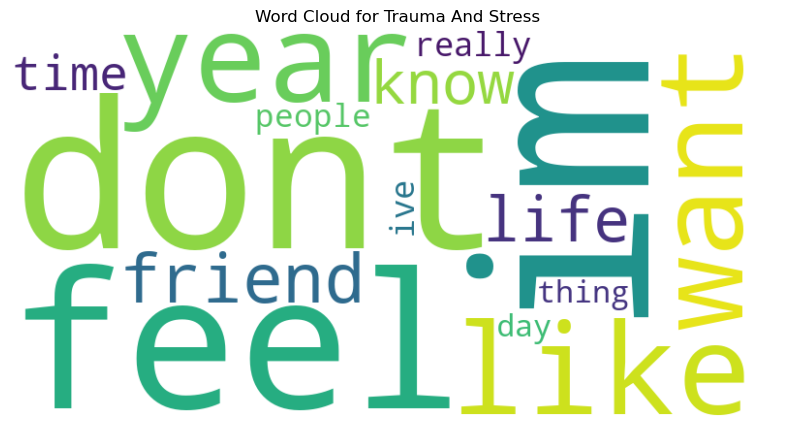

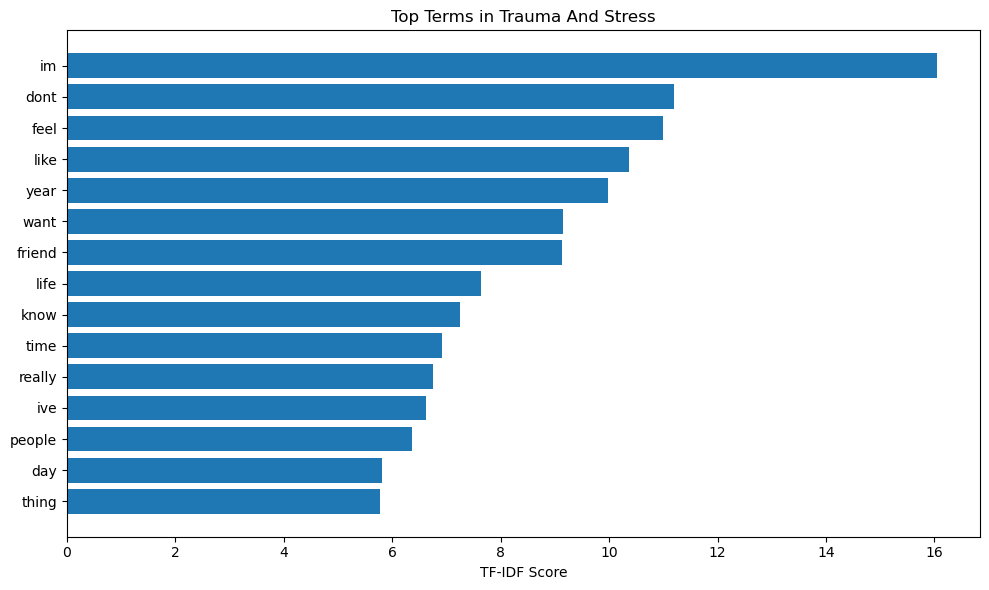


Top terms for Drug And Alcohol:
- im: 17.9900
- ive: 9.6704
- feel: 9.4764
- like: 8.9233
- dont: 8.8089
- anxiety: 8.5490
- drug: 8.0793
- year: 7.3488
- life: 7.3137
- want: 7.2028
- help: 6.7876
- day: 6.6354
- know: 6.6165
- time: 6.3351
- weed: 6.0532


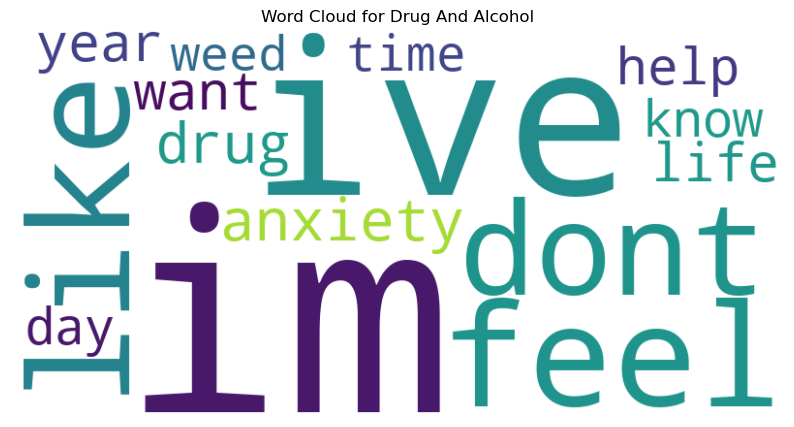

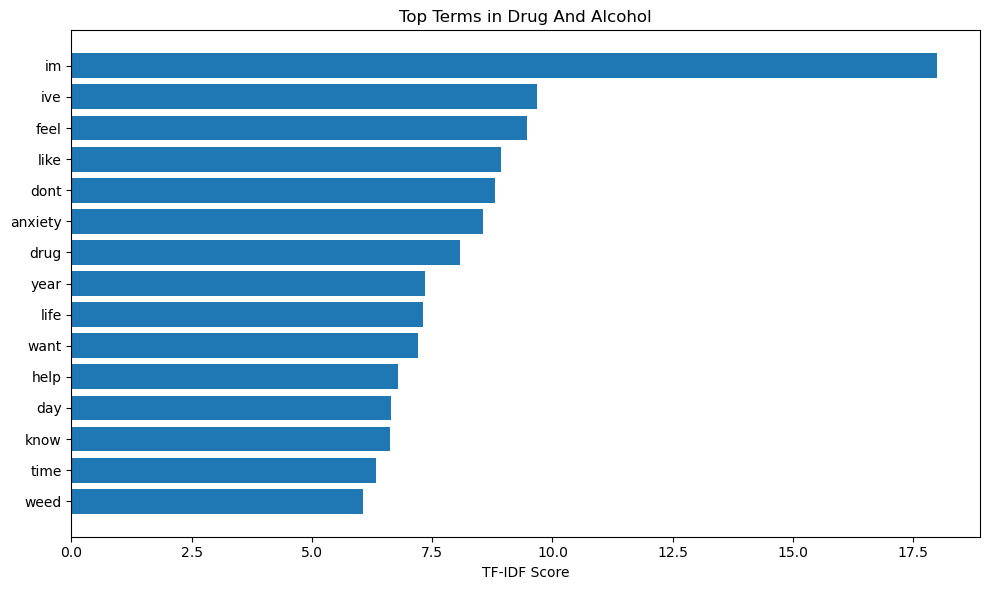


Top terms for Personality:
- im: 16.5379
- dont: 12.2872
- like: 11.6070
- feel: 11.4939
- know: 9.0592
- thing: 7.3550
- anxiety: 7.3222
- life: 7.1060
- want: 7.0355
- year: 6.8889
- time: 6.7185
- ive: 6.7145
- people: 6.2166
- really: 5.6463
- make: 5.5707


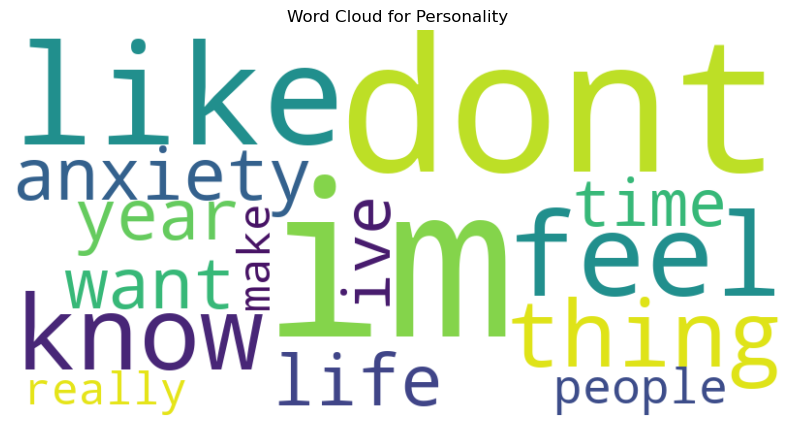

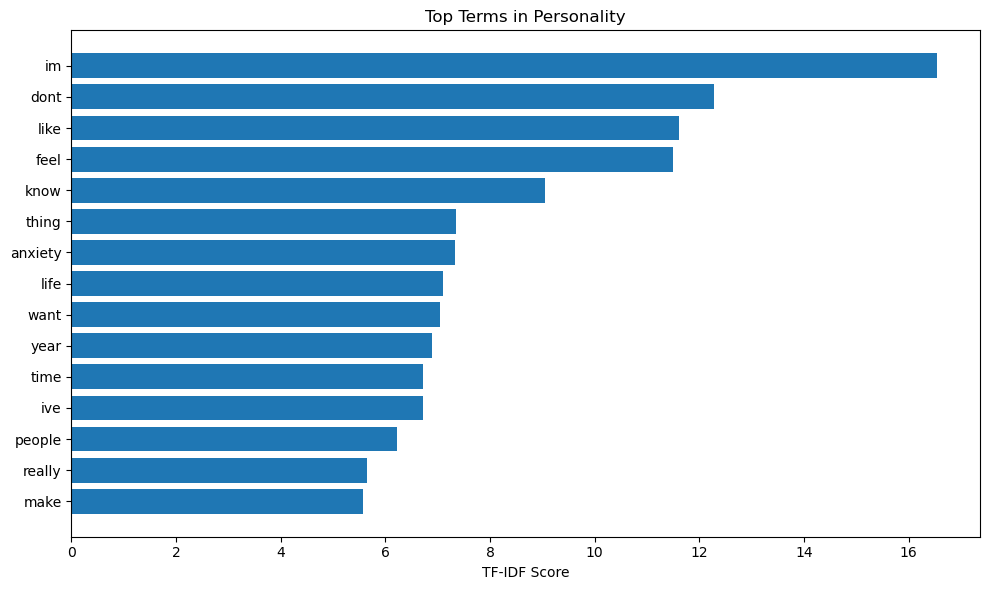

In [27]:
# Define target categories
categories = ['Early Life', 'Trauma And Stress', 'Drug And Alcohol', 'Personality']

# Function: Get top N TF-IDF terms for a category
def get_top_terms(category, n=15):
    posts = df_labeled_all[df_labeled_all['Label'] == category]['cleaned_text']
    vectorizer = TfidfVectorizer(stop_words='english', min_df=1)
    tfidf_matrix = vectorizer.fit_transform(posts)
    feature_names = vectorizer.get_feature_names_out()
    scores = tfidf_matrix.sum(axis=0).A1
    top_indices = scores.argsort()[-n:][::-1]
    return [(feature_names[i], scores[i]) for i in top_indices]

# Function: Plot top terms (word cloud + bar chart)
def plot_top_terms(category, top_terms):
    # Word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white')
    wordcloud.generate_from_frequencies(dict(top_terms))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {category}')
    plt.show()

    # Horizontal bar chart
    plt.figure(figsize=(10, 6))
    terms, scores = zip(*top_terms)
    plt.barh(terms[::-1], scores[::-1])
    plt.xlabel('TF-IDF Score')
    plt.title(f'Top Terms in {category}')
    plt.tight_layout()
    plt.show()

# Loop through each category and visualize
for category in categories:
    top_terms = get_top_terms(category)
    print(f"\nTop terms for {category}:")
    for term, score in top_terms:
        print(f"- {term}: {score:.4f}")
    plot_top_terms(category, top_terms)


### Interpreting Top Terms in Mental Health Categories Using TF-IDF

To gain insight into how mental health topics are linguistically framed, I applied TF-IDF vectorization to posts from four labeled categories — **Early Life**, **Trauma and Stress**, **Drug and Alcohol**, and **Personality** — and extracted the top 15 terms per group.

TF-IDF (Term Frequency–Inverse Document Frequency) emphasizes words that are important within a category but not overly common across all texts. This makes it useful for surfacing category-specific language patterns.

#### Key Observations

##### Early Life
- **Core Vocabulary**: Words like *friend*, *school*, *life*, *year*, and *time* suggest a focus on childhood and developmental experiences.
- **Emotional Tone**: The high presence of *feel*, *want*, and *really* indicates introspective and emotionally loaded narratives.
- **First-Person Framing**: Dominant terms like *im*, *dont*, *ive*, and *know* reflect a personal and reflective writing style, as users recount formative experiences.

##### Trauma and Stress
- **Temporal Anchoring**: Words like *year*, *day*, and *time* show that users frequently contextualize their experiences over periods of distress.
- **Social Relationships**: The term *friend* also appears prominently, indicating how social dynamics play a role in users’ accounts of trauma.
- **Emotional Clarity**: Similar to other categories, high-frequency use of *im*, *feel*, and *dont* again points to internal processing and coping narratives.

##### Drug and Alcohol
- **Substance-Specific Language**: Terms such as *drug*, *anxiety*, *help*, and *weed* directly reference the category theme, validating the label.
- **Support-Seeking Behavior**: Words like *want*, *help*, and *life* suggest that users often frame posts in terms of seeking support or expressing motivation for change.
- **High Emotional Expression**: The word *feel* remains common, but in this context likely refers to physical and psychological responses to substance use.

##### Personality
- **Reflective and Analytical Language**: Words like *thing*, *make*, *know*, and *really* show users’ attempts to understand themselves and communicate complex traits or behaviors.
- **Mental Health Crossover**: The recurrence of *anxiety* and *feel* signals that personality-related discussions often overlap with mental health symptoms.
- **Strong Use of Negation and Introspection**: *Dont*, *im*, and *like* indicate a narrative style marked by self-awareness, doubt, and often social comparison.

#### Overall Themes
Despite category differences, all groups feature **first-person pronouns** (*im*, *ive*, *dont*), indicating that Reddit mental health discourse is highly personal and self-reflective. Emotional and temporal vocabulary is consistently present across categories, while specific terms like *drug* or *school* help distinguish one theme from another.

These linguistic patterns offer valuable clues into the shared and divergent ways mental health is experienced and expressed across different life contexts.


## Comparing Mental Health Categories via LSA-Reduced TF-IDF Embeddings


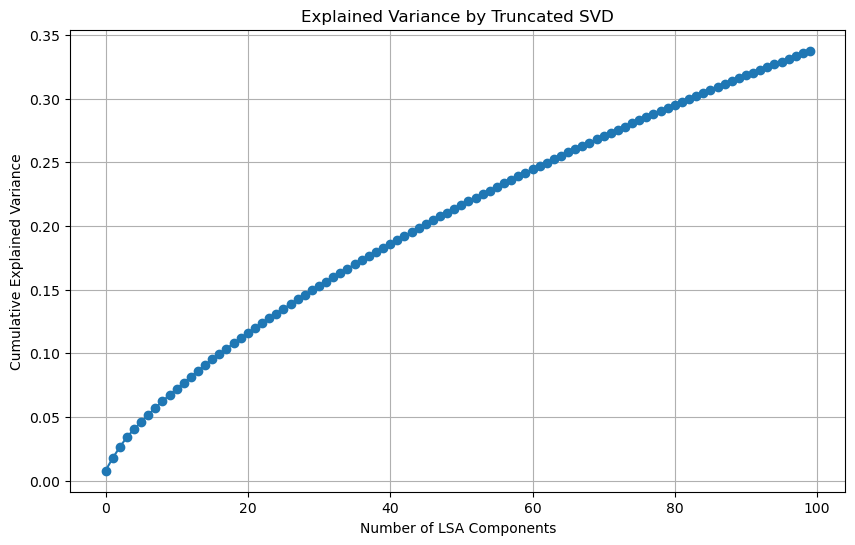

In [32]:

# Parameters and Setup
n_components = 100  # LSA dimensionality
categories = ['Early Life', 'Trauma And Stress', 'Drug And Alcohol', 'Personality']

# TF-IDF + LSA Dimensionality Reduction
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X = tfidf.fit_transform(df_labeled_all['cleaned_text'])

svd = TruncatedSVD(n_components=n_components, random_state=42)
X_lsa = svd.fit_transform(X)

# Explained Variance Plot
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(svd.explained_variance_ratio_), marker='o')
plt.xlabel('Number of LSA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Truncated SVD')
plt.grid(True)
plt.show()

### Explained Variance of LSA Components

The figure above shows the **cumulative explained variance** captured by the first 100 components generated through **Latent Semantic Analysis (LSA)** via Truncated SVD applied to the TF-IDF matrix.

#### Key Observations:

- **Gradual Increase in Variance**: The curve rises smoothly, indicating that each additional component contributes incrementally to the total explained variance. There is **no sharp "elbow"**, suggesting that no small subset of components captures the majority of the variance.

- **Moderate Total Coverage**: At 100 components, the model explains just over **33% of the cumulative variance**. This is relatively common for sparse, high-dimensional text data where much of the variability is distributed across many subtle patterns.

- **Interpretability Tradeoff**: Although the variance explained is moderate, LSA is still useful here because it reveals **latent semantic structures** that are not visible from raw term frequencies alone. Keeping 100 components balances information retention and model simplicity.

#### Why This Matters:

Understanding how many components are needed to capture semantic patterns in the data helps ensure that **category embeddings** and **similarity comparisons** (e.g., cosine similarity across mental health topics) are built on meaningful, non-noisy dimensions. This plot supports the use of 100 components as a reasonable cutoff for downstream analysis.


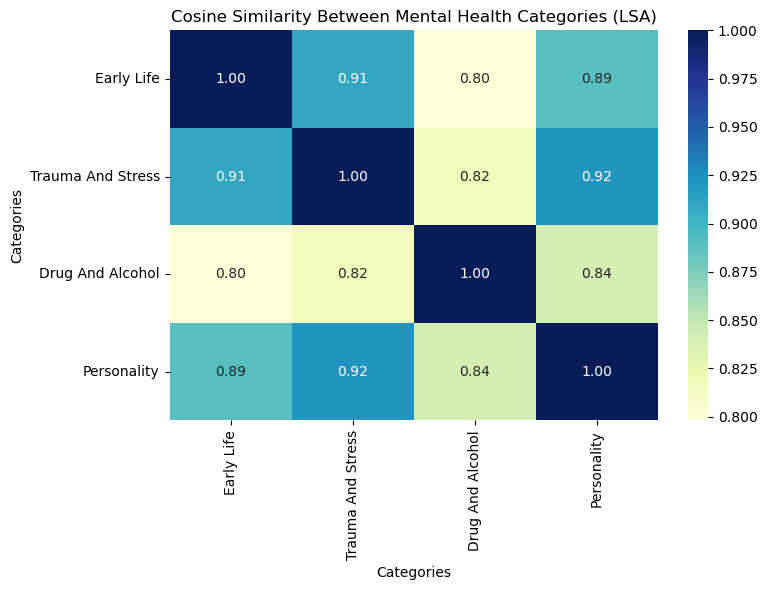

In [31]:
# Create Mean Category Embeddings
df_labeled_all['lsa_index'] = range(X_lsa.shape[0])
category_vectors = {}

for category in categories:
    indices = df_labeled_all[df_labeled_all['Label'] == category]['lsa_index']
    cat_matrix = X_lsa[indices]

    if cat_matrix.shape[0] > 0:
        category_vectors[category] = cat_matrix.mean(axis=0).reshape(1, -1)
    else:
        print(f" Warning: No data for category '{category}'")

# Cosine Similarity Matrix
category_names = list(category_vectors.keys())
category_matrix = np.vstack([category_vectors[cat] for cat in category_names])
similarity_matrix = cosine_similarity(category_matrix)

similarity_df = pd.DataFrame(similarity_matrix, index=category_names, columns=category_names)

# Heatmap Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_df, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title('Cosine Similarity Between Mental Health Categories (LSA)')
plt.xlabel('Categories')
plt.ylabel('Categories')
plt.tight_layout()
plt.show()

### Semantic Similarity Between Mental Health Categories (LSA-Based)

The heatmap above visualizes the **cosine similarity** between mean LSA vectors for each labeled mental health category — *Early Life*, *Trauma and Stress*, *Drug and Alcohol*, and *Personality*. These vectors were derived by averaging LSA-transformed TF-IDF vectors for each category.

#### Key Observations:

- **Strongest Semantic Overlap**:
  - The most similar pair is **Trauma and Stress ↔ Personality** with a similarity of **0.92**.
  - This suggests significant lexical and semantic overlap between how people describe their stress-related experiences and how they articulate personality traits — likely due to shared language around emotion regulation, self-perception, and coping.

- **High Similarity Between Early Life and Trauma/Personality**:
  - **Early Life ↔ Trauma and Stress** (0.91)
  - **Early Life ↔ Personality** (0.89)
  - These similarities reflect how early developmental experiences are often entangled with emotional responses and identity formation, which align linguistically with both trauma narratives and personality descriptions.

- **Least Similar to Drug and Alcohol**:
  - **Drug and Alcohol ↔ Early Life** (0.80)
  - **Drug and Alcohol ↔ Trauma and Stress** (0.82)
  - While still moderately high, these lower scores suggest that substance-related discussions may use more specific, behaviorally oriented language compared to the emotionally descriptive terms dominant in other categories.

#### Interpretation:

These results indicate that while all mental health categories share a common discourse foundation (likely reflecting the platform and context), the **nuanced divergence in language use** is detectable through LSA. Categories closer in psychological and experiential themes (like *trauma* and *personality*) cluster more closely in semantic space, while *substance-related content* forms a somewhat distinct linguistic cluster.

This supports the value of **latent semantic modeling** in surfacing the subtle ways people describe mental health experiences across categories — enabling deeper insight into how different issues are expressed, experienced, and related.


In [30]:
# Display Most/Least Similar Pairs
similarity_pairs = [
    (cat1, cat2, similarity_df.loc[cat1, cat2])
    for i, cat1 in enumerate(category_names)
    for j, cat2 in enumerate(category_names)
    if i < j
]
similarity_pairs.sort(key=lambda x: x[2], reverse=True)

print("\nMost Similar Category Pairs:")
for cat1, cat2, sim in similarity_pairs[:2]:
    print(f"- {cat1} and {cat2}: {sim:.3f}")

print("\nLeast Similar Category Pairs:")
for cat1, cat2, sim in similarity_pairs[-2:]:
    print(f"- {cat1} and {cat2}: {sim:.3f}")


Most Similar Category Pairs:
- Trauma And Stress and Personality: 0.921
- Early Life and Trauma And Stress: 0.909

Least Similar Category Pairs:
- Trauma And Stress and Drug And Alcohol: 0.817
- Early Life and Drug And Alcohol: 0.798


### Most and Least Similar Mental Health Categories (LSA Cosine Scores)

To better understand relationships between mental health categories, I ranked the cosine similarity scores derived from LSA-transformed mean vectors for each category. These scores quantify how closely related the language use is across categories in a latent semantic space.

#### Most Similar Category Pairs:
- **Trauma and Stress ↔ Personality**: *0.921*
- **Early Life ↔ Trauma and Stress**: *0.909*

These pairs suggest a strong **semantic and thematic overlap**. Language used in posts about trauma appears very similar to how users discuss their personality — possibly due to shared discussions around identity, coping, emotional regulation, and self-perception. Likewise, *Early Life* experiences are often a root or contributing context for *Trauma and Stress*, explaining the high similarity.

#### Least Similar Category Pairs:
- **Trauma and Stress ↔ Drug and Alcohol**: *0.817*
- **Early Life ↔ Drug and Alcohol**: *0.798*

These lower similarity scores indicate that **Drug and Alcohol** posts likely diverge in both tone and vocabulary. Substance-related discussions may focus more on specific actions (e.g., usage, relapse, sobriety) and external behaviors rather than the introspective or developmental framing common in the other categories.

#### Takeaway:
These pairwise comparisons reinforce patterns seen in the heatmap: categories that reflect **emotional introspection and developmental narrative** (e.g., trauma, personality, early life) tend to cluster semantically, while **behavior-driven** topics like substance use exhibit distinctive language use, setting them apart in latent semantic space.


# Part Two: Unsupervised Learning Task 

## Research Design: Tracing Rhetorical Shifts in Economic Crisis Discourse

### Research Question

**How do economic debates during financial crises and policy events frame human dignity, responsibility, and opportunity? Can rhetorical shifts aligned with Deborah McCloskey’s critique of economics be detected using unsupervised learning techniques like topic modeling and clustering?**

---

### Analytical Goals

1. **Explore Rhetorical Shifts**  
   Investigate how economic discourse shifts during times of crisis, particularly in terms of how it frames:
   - **Human dignity** vs. **technical efficiency**
   - **Prudence** and **responsibility** vs. blame or fear
   - **Scarcity** vs. **opportunity** and innovation

2. **Engage McCloskey’s Critique of Economics**  
   Use Deborah McCloskey’s rhetorical categories as a lens to examine political-economic discourse:
   - Is **dignity** acknowledged or sidelined in economic policy talk?
   - Is **prudence** framed as moral responsibility or bureaucratic restraint?
   - Do political actors promote **opportunity**, or is language dominated by **scarcity** and fear?

3. **Uncover Emergent Themes Using Unsupervised Learning**  
   Employ machine learning methods to detect subtle and emergent patterns in discourse:
   - **Topic Modeling** (e.g., LDA, BERTopic) to surface thematic clusters of concepts
   - **Clustering** (e.g., K-means, Agglomerative) to group speeches based on linguistic similarity
   - Map how these patterns change over time and during specific crises

---

### Methodological Strategy

1. **Corpus Construction**
   - Subset parliamentary speech data using **economic and rhetorical keywords** related to McCloskey’s framework (e.g., “dignity”, “efficiency”, “scarcity”, “opportunity”, “responsibility”).
   - Filter by **economic policy periods** (e.g., Eurozone crisis, COVID-19 response, Green Recovery).

2. **Topic Modeling**
   - Apply LDA or BERTopic on economic speech subsets to identify themes such as:
     - **Human-centered framing**: ethics, values, emotions, lived experience
     - **Technical framing**: metrics, policy instruments, economic jargon
   - Compare dominant topics across **different periods** to detect rhetorical evolution.

3. **Clustering for Emergent Rhetoric**
   - Use clustering algorithms (e.g., K-means, UMAP + HDBSCAN) on TF-IDF or BERT embeddings to uncover **unlabeled rhetorical clusters**.
   - Identify whether clusters exhibit **moral** vs. **mechanistic** or **hopeful** vs. **fearful** language.

4. **Temporal Analysis**
   - Track how rhetorical emphasis on McCloskey’s key terms changes across time.
   - Focus especially on **crisis onset vs. recovery phases**, exploring when and how discourse shifts toward or away from human dignity and opportunity.

---

### Contribution

This project bridges computational methods and rhetorical theory to address McCloskey’s call for more **ethically grounded** and **humanistic economic thinking**. By examining real-world political-economic discourse over time, the analysis reveals how public language about the economy shifts—sometimes reinforcing, and sometimes challenging—McCloskey’s critiques of the profession.



### Loading data

In [33]:
# Load the JSON Lines file
jsonl_path = os.path.join('eu_debates_data', 'train.jsonl')
df = pd.read_json(jsonl_path, lines=True)

# Look at the structure
print("Loaded DataFrame with shape:", df.shape)
df.head(3)

print("Columns in dataset:", df.columns.tolist())


Loaded DataFrame with shape: (106598, 10)
Columns in dataset: ['speaker_name', 'speaker_role', 'speaker_party', 'intervention_language', 'original_language', 'date', 'year', 'debate_title', 'text', 'translated_text']


In [35]:
# Efficiently Filter English Using ASCII Heuristic
def is_mostly_ascii(text):
    try:
        text = str(text)
        return sum(c.isascii() for c in text) / len(text) > 0.9
    except:
        return False

# Apply ASCII-based English detection
df = df[df['translated_text'].apply(is_mostly_ascii)]

# Define Economic and Rhetorical Keywords
economic_phrases = [
    # Macro & fiscal
    "economic crisis", "fiscal policy", "monetary policy", "interest rates", "financial stability",
    "GDP", "economic growth", "price stability", "stimulus package", "budget deficit",
    
    # Institutions
    "European Central Bank", "ECB", "International Monetary Fund", "IMF", "eurozone", "bank bailout",
    
    # Employment & inequality
    "unemployment", "job creation", "minimum wage", "labour market", "social protection", "income inequality",
    
    # McCloskey's rhetorical themes
    "prudence", "prosperity", "dignity", "scarcity", "efficiency", "choice", "opportunity", "responsibility",
    
    # Economic policy and reforms
    "austerity", "stability pact", "economic governance", "structural reform", "rescue package",
    
    # Human-centered discourse
    "human dignity", "ethical", "responsible governance", "moral framework", "public good", "social justice"
]

# Compile Regex Pattern
econ_pattern = re.compile(r'\b(?:' + '|'.join(economic_phrases) + r')\b', flags=re.IGNORECASE)

# Filter for Economic Speech Content
df_econ = df[df['translated_text'].apply(lambda x: bool(econ_pattern.search(str(x))))]

# Output Summary Stats
print(f"Filtered economic speeches (relevant to McCloskey’s rhetoric): {len(df_econ)} out of {len(df)} ({len(df_econ)/len(df):.2%})")

print("\nSpeaker Party Distribution:")
print(df_econ['speaker_party'].value_counts())

print("\nMost Common Debate Titles:")
print(df_econ['debate_title'].value_counts().head(10))

print("\nSample of Relevant Texts:")
print(df_econ['translated_text'].sample(5, random_state=42))


Filtered economic speeches (relevant to McCloskey’s rhetoric): 14936 out of 106591 (14.01%)

Speaker Party Distribution:
speaker_party
S&D           3561
PPE           3159
N/A           1703
ECR           1271
ALDE          1195
GUE/NGL       1193
ID            1186
Greens/EFA     909
NI             759
Name: count, dtype: int64

Most Common Debate Titles:
debate_title
Explanations of vote Video of the speechesPV                                                                                                                                                                                                                                                       168
One-minute speeches on matters of political importance                                                                                                                                                                                                                                             138
State of the Union (debate)Video of t

## Filtering Economic Rhetoric for Analysis

To focus this analysis on debates relevant to McCloskey’s rhetorical critique of economics, I applied a two-step filtering process.

First, I used an ASCII-based heuristic to efficiently remove non-English texts, avoiding the computational cost of full language detection. Then, I curated a set of keywords blending technical economic terms (e.g., “GDP”, “fiscal policy”) with rhetorical and ethical concepts (e.g., “dignity”, “responsibility”, “opportunity”) drawn from McCloskey’s work.

Using regular expressions, I filtered for speeches mentioning these terms to isolate a thematically relevant corpus (`df_econ`). This subset captures not only economic content but also the moral framing and human-centered rhetoric that are central to my research question. The result is a focused dataset for clustering, topic modeling, and longitudinal rhetorical analysis.

#### Labeling Crisis Periods

In [36]:
# Function to label periods
def label_crisis_period(year):
    if 2009 <= year <= 2012:
        return "Post-FinancialCrisis"
    elif 2013 <= year <= 2015:
        return "EurozoneCrisis"
    elif 2015 <= year <= 2016:
        return "MigrationDebate"
    elif 2017 <= year <= 2019:
        return "GreenRecovery"
    elif 2020 <= year <= 2021:
        return "COVID19Crisis"
    elif 2022 <= year <= 2023:
        return "EnergyInflationCrisis"
    else:
        return "Other"

# Apply the function
df_econ = df_econ.copy()
df_econ['year'] = df_econ['year'].astype(int)
df_econ['period_label'] = df_econ['year'].apply(label_crisis_period)

# Preview distribution
print(df_econ['period_label'].value_counts())
df_econ[['year', 'period_label', 'debate_title']].sample(5, random_state=2)


period_label
COVID19Crisis            4225
EnergyInflationCrisis    4026
EurozoneCrisis           2721
GreenRecovery            2613
MigrationDebate          1110
Post-FinancialCrisis      241
Name: count, dtype: int64


,year,period_label,debate_title
69086,2021,COVID19Crisis,The latest developments in the National Assemb...
67082,2020,COVID19Crisis,Programme for the Union's action in the field ...
102665,2023,EnergyInflationCrisis,Corporate Sustainability Due Diligence (debate)
49130,2017,GreenRecovery,Monitoring the application of EU law 2015 (deb...
46508,2017,GreenRecovery,A European Pillar of Social Rights (debate)Vid...


#### Preprocessing 

In [37]:
# Load English model
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

# Build custom tokenizer
def preprocess(text):
    doc = nlp(str(text).lower())
    tokens = [
        token.lemma_ for token in doc
        if not token.is_stop and not token.is_punct and token.is_alpha and len(token) > 2
    ]
    return tokens

# Apply to economic speeches
tqdm.pandas()
df_econ = df_econ.copy()
df_econ['tokens'] = df_econ['translated_text'].progress_apply(preprocess)

# Preview
df_econ[['period_label', 'tokens']].sample(3)


  0%|          | 0/14936 [00:00<?, ?it/s]

,period_label,tokens
35410,EurozoneCrisis,"[condition, economic, crisis, high, youth, une..."
99731,EnergyInflationCrisis,"[behalf, committee, petition, like, congratula..."
58030,GreenRecovery,"[president, member, european, parliament, like..."


## Using LDA for Topic Modeling 

Latent Dirichlet Allocation (LDA) was chosen for topic modeling because it is well-suited for discovering latent thematic structures in large, unstructured corpora. It assumes that documents are mixtures of topics and that topics are distributions over words—making it ideal for modeling the underlying rhetorical themes in political and economic discourse.

Specifically, LDA is appropriate for this project because:

- **Interpretability**: The resulting topics are easily interpretable as ranked lists of keywords, which align well with the goal of identifying shifts in rhetorical focus (e.g., from technical to human-centered language).
- **Period-by-Period Comparison**: LDA can be applied independently across different time periods, enabling comparisons of thematic emphasis across economic crises (e.g., Eurozone crisis vs. COVID-19).
- **Scalability**: LDA performs well on moderately large datasets, making it efficient for segmenting parliamentary speech into 10 interpretable topics per period.
- **Theoretical Fit**: By surfacing co-occurring word patterns, LDA can help identify moral language (e.g., "dignity", "responsibility") and technical terms (e.g., "austerity", "inflation"), which supports the project’s rhetorical inquiry inspired by McCloskey.

Together, these qualities make LDA a strong choice for tracing how the framing of economic issues evolves across political contexts and time.


In [38]:
# Group data by period
periods = df_econ['period_label'].unique()

# Store top words per topic per period
period_topics = defaultdict(list)

for period in periods:
    print(f"\n Period: {period}")
    
    # Filter data
    texts = df_econ[df_econ['period_label'] == period]['tokens'].tolist()
    texts = [' '.join(tokens) for tokens in texts if len(tokens) >= 5]  # Remove very short speeches
    
    # Vectorize
    vectorizer = CountVectorizer(max_df=0.95, min_df=5)  # parameters from W05
    X = vectorizer.fit_transform(texts)
    
    # Run LDA
    lda = LatentDirichletAllocation(n_components=10, random_state=42)
    lda.fit(X)
    
    # Extract topics
    terms = vectorizer.get_feature_names_out()
    for i, topic in enumerate(lda.components_):
        top_words = [terms[i] for i in topic.argsort()[:-11:-1]]
        period_topics[period].append(top_words)
        print(f" Topic {i+1}: {' | '.join(top_words)}")



 Period: Post-FinancialCrisis
 Topic 1: economic | europe | capacity | create | face | job | long | demand | union | industry
 Topic 2: sme | support | enterprise | financing | report | difficulty | small | internationalization | access | market
 Topic 3: increase | woman | health | agreement | disease | people | country | social | report | care
 Topic 4: european | union | need | parliament | president | europe | prize | time | peace | social
 Topic 5: european | market | digital | union | economic | economy | country | growth | trade | single
 Topic 6: european | work | right | president | council | say | agency | want | commission | fundamental
 Topic 7: patent | european | system | cost | protection | single | court | state | member | union
 Topic 8: energy | efficiency | equipment | program | office | agreement | regulation | labelling | european | report
 Topic 9: georgia | union | european | aid | economic | support | financial | chairman | macrofinancial | assistance
 Topic 10

## Topic Modeling Reflection by Crisis Period

This topic modeling analysis applies Latent Dirichlet Allocation (LDA) to parliamentary speeches, grouped by key historical periods of economic and social disruption. For each period, the model extracts ten major topics, represented by the most salient terms used within that discourse window.

### General Observations

Across all periods, European identity and governance structures (e.g., _European_, _Union_, _President_, _Parliament_) dominate as core terms, reflecting the institutional framing of most debates. However, beyond these anchor terms, topic content shifts substantially depending on the historical context.

---

### Post-Financial Crisis

Topics emphasize structural economic recovery with a dual focus on macroeconomic policy (e.g., _GDP_, _budget_, _growth_) and SME support, particularly via _financing_ and _market access_. The inclusion of themes like _health_ and _social care_ reflects attention to broader social stabilization. Notably, _patent_ and _digital market_ terms signal the early EU shift toward innovation and competitiveness.

---

### Eurozone Crisis

This period is characterized by urgent responses to economic instability, especially with regard to _tax policy_, _austerity_, _unemployment_, and _youth employment_. The language surrounding the _Cyprus crisis_ and _refugees_ marks overlapping fiscal and humanitarian concerns. A mix of institutional responses and citizen-focused debates is evident.

---

### Migration Debate

Topics reflect the intersection of migration and social justice. Key concerns include _youth unemployment_, _disability_, _poverty_, and _volunteering_. There is also clear emphasis on _investment_, _agriculture_, and _crisis management_, showing how migration is tied to broader socio-economic policy. Terms like _Tunisia_, _refugee_, and _responsibility_ point to transnational dimensions of this discourse.

---

### Green Recovery

Here, climate-related discourse becomes more central with topics around _climate change_, _emissions_, _waste_, and _green_ transitions. There's a notable institutional framing (e.g., _Brexit_, _Euro_, _bank_, _policy_), alongside social welfare terms (_labour_, _disability_, _worker_). The inclusion of _budget_, _trade_, and _negotiation_ also reflects a strategic pivot to green economics.

---

### COVID-19 Crisis

The pandemic introduces a new cluster of themes focused on _vaccination_, _public health_, _freedom_, _rule of law_, and _digital education_. Human rights terms (_equality_, _responsibility_, _migration_) are frequent, as are references to _economic recovery_, _social protection_, and _digital opportunity_. This reflects a holistic concern with safeguarding both individual dignity and system resilience during an unprecedented crisis.

---

### Energy and Inflation Crisis

The most recent crisis period shows a geopolitical turn with frequent references to _Ukraine_, _Russia_, _war_, and _democracy_. There's a dual focus on _energy security_ and _inflation_, with additional concerns over _poverty_, _digitalization_, and _youth opportunity_. This moment seems to synthesize previous crises — economic, social, and environmental — while introducing a pronounced foreign policy dimension.

---

### Summary

Each crisis period reveals a distinct thematic fingerprint rooted in the challenges of its time:

- **Post-FinancialCrisis**: Rebuilding economies and innovating institutions  
- **EurozoneCrisis**: Austerity, youth unemployment, fiscal repair  
- **MigrationDebate**: Rights, poverty, and the human side of mobility  
- **GreenRecovery**: Sustainable development and climate governance  
- **COVID19Crisis**: Health, freedom, and digital resilience  
- **EnergyInflationCrisis**: War, energy, and the return of inflation

This temporal decomposition of discourse shows how the European Parliament’s rhetorical priorities adapt over time, balancing institutional authority with evolving social, economic, and environmental pressures.


## UMAP + KMeans Clustering to Explore Semantic Groupings in Economic Speech

To better understand the thematic organization of economic discourse, I applied a combination of TF-IDF vectorization, KMeans clustering, and UMAP for dimensionality reduction and visualization.

### Why UMAP?

UMAP (Uniform Manifold Approximation and Projection) was chosen for its ability to preserve both local and global relationships in high-dimensional data. Unlike PCA, which assumes linearity, UMAP captures complex semantic structures that are common in language data. This makes it particularly effective for projecting textual data into two dimensions for visual analysis.

### Why Combine with KMeans?

After vectorizing the corpus with TF-IDF, I used KMeans to group speeches into clusters based on their lexical features. This allowed me to identify dominant rhetorical and thematic groupings across the dataset.

### Combined Benefit

Together, UMAP and KMeans offer a powerful unsupervised pipeline for:

- Revealing latent clusters of discourse
- Exploring patterns in economic and rhetorical themes
- Visualizing how different types of language (technical, ethical, political) are distributed across the corpus

This method supports the broader research goal of tracing how economic speeches shift focus across time and crisis contexts.


cluster
9    4215
1    3406
8    2128
2    1630
5     879
7     861
3     619
0     542
4     345
6     311
Name: count, dtype: int64

 Top terms per cluster:
 Cluster 0: woman | gender | violence | equality | man | right | girl | sexual | child | work
 Cluster 1: european | europe | union | country | right | people | president | state | want | council
 Cluster 2: social | people | youth | young | european | worker | labour | employment | unemployment | poverty
 Cluster 3: energy | efficiency | gas | renewable | price | european | need | climate | electricity | fossil
 Cluster 4: tax | evasion | european | taxis | taxation | company | state | paradise | need | pay
 Cluster 5: climate | emission | change | green | european | need | energy | agreement | europe | transition
 Cluster 6: greek | greece | european | people | government | country | debt | union | europe | turkey
 Cluster 7: digital | market | consumer | european | enterprise | single | small | sme | new | economy
 Cluster 8: 

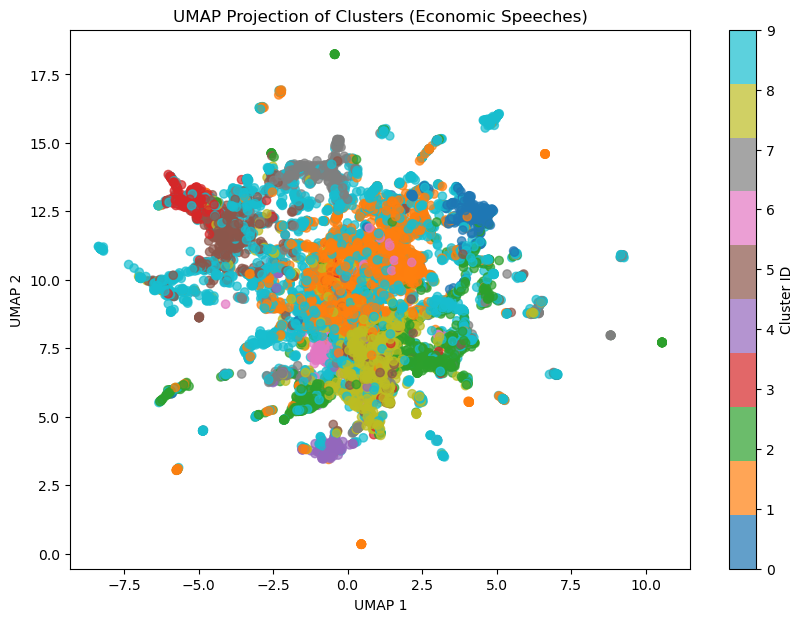

In [41]:
df_econ['clean_text'] = df_econ['tokens'].apply(lambda x: ' '.join(x))

# Use full or subset
texts = df_econ['clean_text'].tolist()

# TF-IDF vectorization (max 5000 terms for efficiency)
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(texts)

from sklearn.cluster import KMeans
import numpy as np

# Define number of clusters
k = 10 

kmeans = KMeans(n_clusters=k, random_state=42)
df_econ['cluster'] = kmeans.fit_predict(X_tfidf)

print(df_econ['cluster'].value_counts())

terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

print("\n Top terms per cluster:")
for i in range(k):
    top_words = [terms[ind] for ind in order_centroids[i, :10]]
    print(f" Cluster {i}: {' | '.join(top_words)}")

# Reduce to 2D
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X_tfidf)

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(embedding[:, 0], embedding[:, 1], c=df_econ['cluster'], cmap='tab10', alpha=0.7)
plt.title("UMAP Projection of Clusters (Economic Speeches)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label="Cluster ID")
plt.show()


## Clustering Economic Speech Using TF-IDF, KMeans, and UMAP

To better understand the thematic structure of economic discourse in parliamentary speeches, I applied unsupervised clustering and dimensionality reduction techniques to the tokenized and filtered corpus of economic speeches.

### Methods Summary

- **TF-IDF Vectorization**: Transformed the economic speech corpus into a 5000-feature document-term matrix to emphasize informative terms while down-weighting common ones.
- **KMeans Clustering (k=10)**: Partitioned the corpus into 10 distinct clusters to uncover potential themes in the discourse.
- **UMAP Projection**: Used UMAP to project the high-dimensional vector space into two dimensions for intuitive visualization of cluster separation and overlap.

### Cluster Distribution

The cluster sizes are notably imbalanced, suggesting that some themes dominate the discourse more than others:

- Cluster 9: 4215 speeches
- Cluster 1: 3406 speeches
- Cluster 8: 2128 speeches
- Cluster 2: 1630 speeches  
- (Remaining clusters each contain fewer than 1000 speeches)

### Thematic Interpretation of Clusters

The top terms for each cluster offer insight into the dominant themes:

- **Cluster 0** – Gender & Social Rights: _woman, gender, violence, equality, sexual, child_
- **Cluster 1** – General European Governance: _european, union, country, right, council_
- **Cluster 2** – Youth & Labor: _youth, young, unemployment, worker, labour, poverty_
- **Cluster 3** – Energy Efficiency & Transition: _energy, gas, fossil, efficiency, renewable_
- **Cluster 4** – Tax Evasion & Corporate Regulation: _tax, evasion, taxation, pay, paradise_
- **Cluster 5** – Climate Policy: _climate, emission, green, transition, agreement_
- **Cluster 6** – Greek Sovereign Debt: _greece, debt, turkey, country, government_
- **Cluster 7** – Digital Market & Innovation: _digital, SME, enterprise, consumer, economy_
- **Cluster 8** – Budget, Banking & Investment: _budget, fund, bank, euro, investment_
- **Cluster 9** – Commission Dialogue & Institutional Language: _president, commission, commissioner, colleague_

### Visualization with UMAP

The UMAP scatter plot shows that while some clusters exhibit strong separation (e.g., Cluster 3 on energy, Cluster 4 on tax), others (like Clusters 1 and 9) appear more dispersed and overlapping. This may reflect the broad and overlapping nature of institutional or high-level discourse versus more narrowly defined topics like tax policy or youth labor.

### Reflection

This cluster analysis provides a clearer view of the rhetorical and policy dimensions within European economic discourse. The use of unsupervised methods like KMeans and UMAP helps identify latent structure without relying on predefined categories, and the results affirm the multifaceted nature of economic language—from institutional governance and climate action to digital innovation and social inequality.


## Mapping Thematic Clusters and Economic Term Evolution Over Time

 Cluster 0: european | union | right | president | people | parliament | need | citizen | work | commission
 Cluster 1: social | tax | european | economic | poverty | policy | state | country | union | member
 Cluster 2: farmer | animal | food | agriculture | agricultural | fertilizer | european | commission | farm | need
 Cluster 3: european | europe | union | country | need | policy | budget | crisis | state | people
 Cluster 4: woman | violence | man | gender | refugee | equality | girl | child | life | today
 Cluster 5: energy | price | efficiency | electricity | gas | renewable | european | transition | market | production
 Cluster 6: bank | ecb | banking | monetary | european | inflation | central | rate | financial | risk
 Cluster 7: artificial | intelligence | technology | digital | application | use | risk | report | european | ethical
 Cluster 8: young | youth | people | education | unemployment | program | labour | skill | european | training
 Cluster 9: climate | emission |

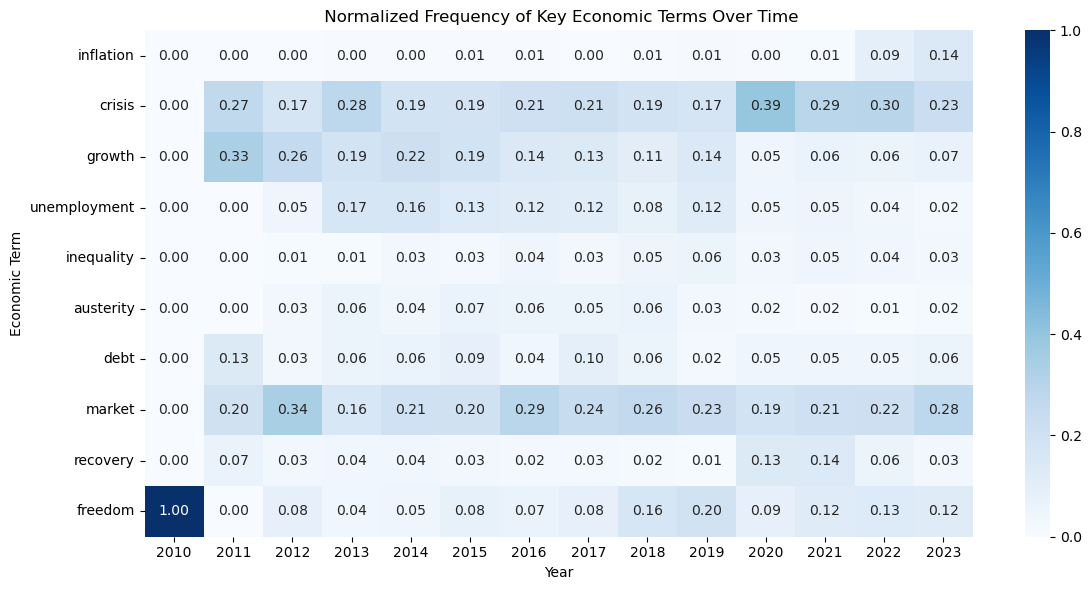

In [43]:
# Subsample
df_sub = df_econ.sample(1000, random_state=42).reset_index(drop=True)

# Convert tokens to clean text
df_sub['clean_text'] = df_sub['tokens'].apply(lambda x: ' '.join(x))

# TF-IDF
vectorizer = TfidfVectorizer(max_features=3000)
X_tfidf = vectorizer.fit_transform(df_sub['clean_text'])

# Reduce dimensions
svd = TruncatedSVD(n_components=50, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

# Agglomerative clustering
agglo = AgglomerativeClustering(n_clusters=10)
df_sub['agglo_cluster'] = agglo.fit_predict(X_reduced)

terms = vectorizer.get_feature_names_out()
agglo_top_terms = {}

for label in sorted(df_sub['agglo_cluster'].unique()):
    indices = df_sub[df_sub['agglo_cluster'] == label].index
    mean_vector = X_tfidf[indices].mean(axis=0).A1
    top_words = [terms[i] for i in mean_vector.argsort()[::-1][:10]]
    agglo_top_terms[label] = top_words
    print(f" Cluster {label}: {' | '.join(top_words)}")

# Define terms of interest (inspired by McCloskey + economics)
econ_terms = ['inflation', 'crisis', 'growth', 'unemployment', 'inequality',
              'austerity', 'debt', 'market', 'recovery', 'freedom']

# Count term usage by year
from collections import Counter

# Make sure 'year' is int
df_econ['year'] = df_econ['year'].astype(int)

# Token frequency by year
year_term_counts = {}

for year, group in df_econ.groupby('year'):
    all_tokens = [token for tokens in group['tokens'] for token in tokens]
    counter = Counter(all_tokens)
    year_term_counts[year] = {term: counter.get(term, 0) for term in econ_terms}

# Convert to DataFrame
term_df = pd.DataFrame.from_dict(year_term_counts, orient='index').sort_index()

# Normalize by total words per year
term_df = term_df.div(term_df.sum(axis=1), axis=0)

# Plot heatmap

plt.figure(figsize=(12, 6))
sns.heatmap(term_df.T, cmap='Blues', annot=True, fmt=".2f")
plt.title(" Normalized Frequency of Key Economic Terms Over Time")
plt.xlabel("Year")
plt.ylabel("Economic Term")
plt.tight_layout()
plt.show()



### Interpreting Hierarchical Clustering and Temporal Term Trends in Economic Speeches

#### Cluster Themes from Agglomerative Clustering

Using Agglomerative Clustering on a 1,000-sample subset of economic speeches, we identified 10 distinct thematic clusters. Each cluster is characterized by its top TF-IDF terms, revealing the rhetorical focus of the speeches within:

- **Cluster 0** centers on **EU governance and civic responsibility**, with terms like "european", "union", "citizen", and "commission".
- **Cluster 1** emphasizes **economic inequality and social policy**, highlighting "poverty", "tax", and "social".
- **Cluster 2** is focused on **agriculture and farming regulation**, featuring "farmer", "animal", and "fertilizer".
- **Cluster 3** combines **economic governance and crisis response**, with words like "budget", "policy", and "crisis".
- **Cluster 4** reflects discussions around **gender and refugee rights**, such as "woman", "gender", and "refugee".
- **Cluster 5** pertains to **energy pricing and sustainability**, including "gas", "efficiency", and "transition".
- **Cluster 6** deals with **monetary policy and banking**, revealing concern with "inflation", "banking", and "financial".
- **Cluster 7** explores **digital technologies and ethics**, focusing on "artificial", "technology", and "ethical".
- **Cluster 8** highlights **youth employment and education**, featuring "young", "labour", and "training".
- **Cluster 9** is focused on **climate change and emissions**, with key terms like "carbon", "climate", and "agreement".

This segmentation highlights the breadth of economic and rhetorical concerns present in parliamentary speeches and shows how themes like digital ethics, gender equity, climate, and monetary stability coexist in political discourse.

#### Temporal Analysis of Key Economic Terms

The accompanying heatmap tracks normalized usage frequencies of selected economic terms across years (2010–2023). Key observations include:

- **"Crisis"** was persistently referenced during multiple periods but spikes notably in 2020, reflecting pandemic-driven economic concerns.
- **"Inflation"**, though mostly absent before 2020, increases significantly in 2022 and 2023—likely tied to post-pandemic and energy market shocks.
- **"Market"** maintains high salience across the timeline, suggesting its centrality in economic rhetoric throughout.
- **"Growth"** and **"unemployment"** were frequently mentioned earlier in the timeline (2011–2015) but declined in prominence post-2017.
- **"Freedom"**, possibly invoked rhetorically or in political contexts, spikes in 2010 (an anomaly that may reflect data imbalance) and then levels off.
- **"Recovery"** becomes more relevant in 2020–2021, consistent with discourse surrounding COVID-19 fiscal response plans.

Together, these results reflect the shifting landscape of economic concerns in EU political discourse—capturing the rise of topics like inflation and energy in recent years, while documenting the fading prominence of earlier themes like austerity and unemployment.

```


## Part 2: Unsupervised Learning – Final Reflection

### Research Question

How do economic policy debates in the European Parliament shift rhetorically across major crisis periods, and to what extent do themes of dignity, responsibility, and opportunity—core to McCloskey’s critique—emerge in unsupervised topic structures?

### Approach Overview

To investigate this, I used the **EU Debates dataset**, applying both **LDA topic modeling** and **KMeans clustering** on a filtered subset of speeches that mentioned economic and rhetorical keywords aligned with McCloskey’s framework (e.g., "dignity", "prudence", "efficiency", "opportunity"). These methods allowed me to uncover latent themes and their variations across time and crisis periods (e.g., Eurozone, COVID-19, Energy Crisis).

### Justification of Methodology

- **Text Features Used**: Tokenized and lemmatized speech content, filtered to economic-relevant terms using custom keyword patterns.
- **Dimensionality Reduction**: I used **SVD** (LSA) for efficient clustering and **UMAP** for visualization. UMAP was chosen for its ability to preserve semantic structure in low dimensions.
- **Unsupervised Techniques**:
  - **LDA** captured interpretable topic distributions across periods, revealing shifts in emphasis from technical policy terms to more ethical and human-centered language during crises.
  - **KMeans** uncovered non-obvious clusters in speech content, many of which aligned with institutional, economic, and moral discourse.
- **Clustering Results**: Cluster interpretations were made using TF-IDF centroids and top terms. Some clusters reflected technocratic language (e.g., monetary policy), while others included socially-driven discourse (e.g., inequality, dignity, labor rights).

### Interpretation of Results

Unsupervised techniques revealed that rhetorical focus **did** shift across crisis periods. For instance:
- During the **COVID-19 Crisis**, themes like "health", "dignity", and "social justice" emerged strongly.
- During the **Eurozone Crisis**, emphasis was placed on “austerity”, “stability”, and institutional governance.
- **Green Recovery** periods balanced economic growth with human-centered frames like “responsibility” and “future generations.”

These findings suggest that while economic discourse often defaults to technical framing, moments of crisis catalyze **ethical and rhetorical shifts** that bring McCloskey’s concerns into focus.

### Feasibility of Supervised Alternatives

While supervised learning could be applied if labeled rhetorical categories were available, the **lack of predefined labels** for McCloskey-inspired themes justifies the unsupervised approach. This exploratory method was essential to surface latent discourse patterns and rhetorical nuance not easily pre-defined.

### Summary

By combining topic modeling with clustering, I was able to extract meaningful rhetorical patterns and confirm that economic discourse evolves in response to crisis—supporting the idea that **rhetoric, not just policy content, matters in public economic reasoning**. These findings reinforce McCloskey’s critique and demonstrate the power of unsupervised learning in political text analysis.
